In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_3152\906459842.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [2]:
data = pd.read_csv("mnist_train_small.csv", header=None)

# extract labels (number ID's) and remove from data
labels = data.values[:, 0]  # Convert DataFrame to NumPy before slicing
data = data.values[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data/np.max(data)

In [4]:
# Ensure labels is a PyTorch tensor
labelsT = torch.tensor(labels).long()  # Ensure it's long for classification

# Convert boolean indexing to work with tensors
where7 = labelsT == 7

# Ensure data is a PyTorch tensor
dataT = torch.tensor(dataNorm).float()

# Separate data and labels
dataNo7 = dataT[~where7]
labelsNo7 = labelsT[~where7]
data7 = dataT[where7]

# Convert into Pytorch Datasets
train_data = TensorDataset(dataNo7, labelsNo7)  # Ensure both have the same first dimension
test_data = TensorDataset(data7)  # No labels needed

# Create DataLoader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(data7))  # Use full batch for test

In [5]:
np.unique(labelsNo7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

In [6]:
# creating a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x), axis = 1)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01) # Adam performs way too good for this model therefore we used SGD

    return net, lossfun, optimizer

In [7]:
 # train the model

def trainTheModel():

    # training parameter
    numepochs = 100
    
    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()
    
    trainAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)
        
    # function output
    return trainAcc, losses, net

In [8]:
trainAcc, losses, net = trainTheModel()

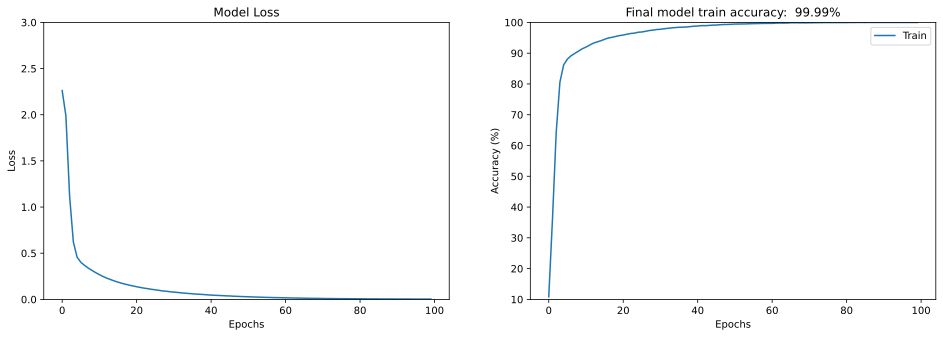

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model Loss")

ax[1].plot(trainAcc, label = "Train")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model train accuracy: {trainAcc[-1]: .2f}%")
ax[1].legend()

plt.show()

In [10]:
# run the model thru for the test data
X = next(iter(test_loader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions, axis = 1).detach()

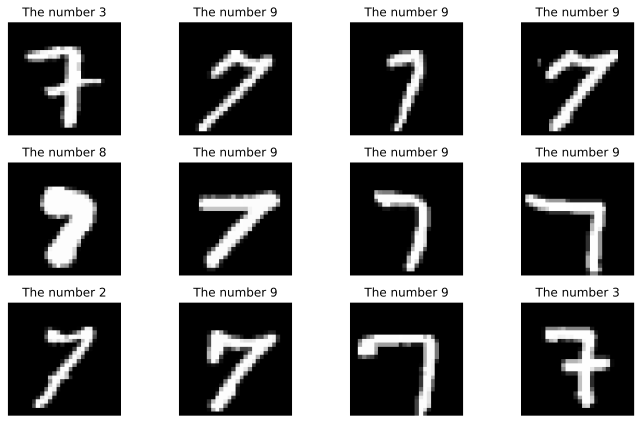

In [11]:
# show some 7's and their labels

fig, axs = plt.subplots(3, 4,figsize = (10, 6))

someRandom7s = np.random.choice(len(X), 12)

for i, ax in enumerate(axs.flatten()):
    thisimg = X[someRandom7s[i]].view(28, 28)
    ax.imshow(thisimg, cmap = "gray")
    ax.set_title(f"The number {guesses[someRandom7s[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


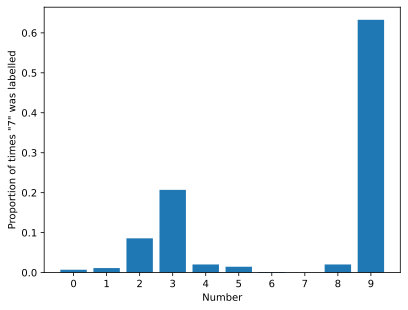

In [14]:
# which numbers are most likely to be confused with 7?
print(np.unique(guesses))

probMistaken = np.zeros(10)

for i in range(10):
    probMistaken[i] = torch.mean((guesses == i).float())

plt.bar(range(10), probMistaken)
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel('Proportion of times "7" was labelled')
plt.show()

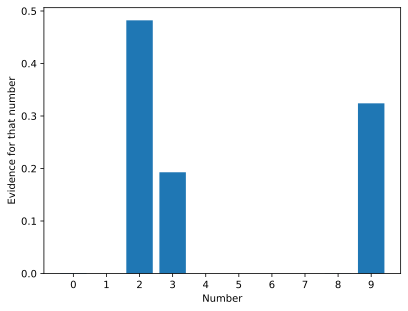

In [15]:
# Evidence for all numbers from one sample
sample2show = 12

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence for that number")
plt.show()